# 1.
Продолжите анализировать эффективность рекламы онлайн-игры «Королевство гномов»: выясните, как различается удержание платящих и неплатящих игроков.
Для этого вызовите заданную в коде функцию get_retention().
Задайте горизонт анализа — 14 дней.
Момент анализа совпадает с максимально возможной датой привлечения и сохранён в переменной observation_date.
Затем постройте один график с кривыми удержания для платящих и неплатящих игроков.
Не отображайте размеры когорт и удержание первого дня.
Добавьте на график сетку и подпишите лайфтаймы по горизонтальной оси.
В профили пользователей дата-инженеры добавили два новых признака:

    payer — совершение покупки.
    Принимает True, если игрок что-нибудь купил у компании, и False в обратном случае.
    channel — источник привлечения.
    В данных встречается три источника: Organic — естественный, органический трафик, а также VaporStore и BattleYes — популярные сети распространения игр.

Подсказка
Задайте горизонт анализа, присвоив переменной analysis_horizon значение 14.
Затем вызовите функцию get_retention(), передав ей переменные users, visits, observation_date и analysis_horizon.
Результат вызова сохраните в переменные, например retention_raw и retention.
Чтобы исключить размеры когорт и удержание первого дня, примените к таблице удержания метод drop(), передав параметру columns список столбцов: ['cohort_size', 0], и сохраните результат в новой переменной, например report.
Затем транспонируйте полученную таблицу атрибутом T и вызовите метод plot(), передав ему True в качестве параметра grid и list(report.columns.values) в качестве параметра xticks.

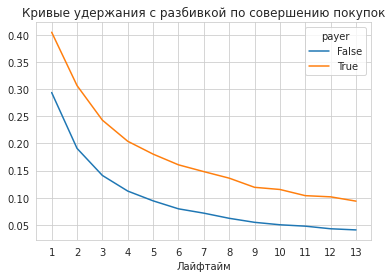

In [4]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt


def get_retention(
        profiles,
        sessions,
        observation_date,
        horizon_days,
        dimensions=[],
        ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
            result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=dimensions,
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
        ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped


# загружаем данные
users = pd.read_csv('datasets/ch02_problems02_users.csv')  # профили
visits = pd.read_csv('datasets/ch02_problems02_visits.csv')  # журнал сессий

# преобразование данных о времени
users['dt'] = pd.to_datetime(users['dt']).dt.date
users['first_ts'] = pd.to_datetime(users['first_ts'])
visits['session_start'] = pd.to_datetime(visits['session_start'])

observation_date = users['dt'].max()  # момент анализа
analysis_horizon = 14
# задайте горизонт анализа
raw_retention, retention = get_retention(profiles=users, sessions=visits, observation_date=observation_date, horizon_days=analysis_horizon)
# получите сырые данные и таблицу удержания
report = retention.drop(columns=['cohort_size', 0])
# исключите размеры когорт и удержание первого дня
report.T.plot(grid=True,
              xticks=list(report.columns.values))
# постройте кривые удержания
plt.xlabel('Лайфтайм')
plt.title('Кривые удержания с разбивкой по совершению покупок')
plt.show()

# 2.
Постройте кривые удержания игроков c разбивкой по источникам привлечения channel.
Применяя функцию subplots(), cделайте два графика: один для платящих пользователей, другой для неплатящих.
Не отражайте в подписях по вертикальной оси значение payer.
Добавьте на графики сетку и сделайте лайфтаймы подписями по горизонтальной оси.

Подсказка
Снова вызовите функцию get_retention(), но на этот раз добавьте параметр dimensions со значением ['channel'].
Чтобы задать цикл for, вызовите функцию enumerate(), передайте ей уникальные значения столбца payer из датафрейма users, а результаты сохраните в переменные цикла, например i и payer.
В теле цикла отфильтруйте таблицу удержания в report методом query(): в запросе установите значение столбца payer равным значению переменной цикла payer.
Чтобы отличить одно от другого, используйте оператор @.
Удалите из индексов слой payer методом droplevel(), транспонируйте таблицу при помощи атрибута T и вызовите метод plot(), передав параметру grid значение True, параметру xticks — list(report.columns.values), а параметру ax — результат вызова subplot(): plt.subplot(1, 2, i + 1).

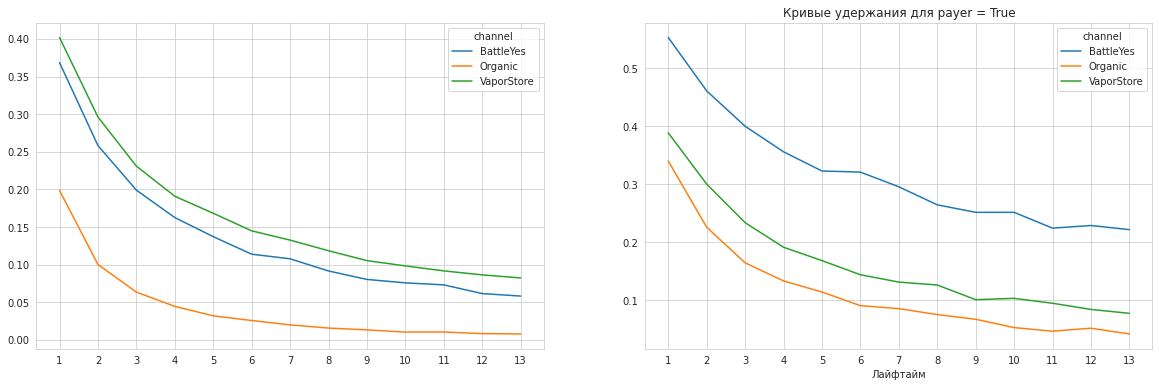

In [7]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt


def get_retention(
        profiles,
        sessions,
        observation_date,
        horizon_days,
        dimensions=[],
        ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
            result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=dimensions,
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
        ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped


# загружаем данные
users = pd.read_csv('datasets/ch02_problems02_users.csv')  # профили
visits = pd.read_csv('datasets/ch02_problems02_visits.csv')  # журнал сессий

# преобразование данных о времени
users['dt'] = pd.to_datetime(users['dt']).dt.date
users['first_ts'] = pd.to_datetime(users['first_ts'])
visits['session_start'] = pd.to_datetime(visits['session_start'])

observation_date = users['dt'].max()  # момент анализа

analysis_horizon = 14  # горизонт анализа

retention_raw, retention = get_retention(profiles=users,
                                         sessions=visits,
                                         observation_date=observation_date,
                                         horizon_days=analysis_horizon,
                                         dimensions=['channel'])# получите сырые данные и таблицу удержания

# исключаем размеры когорт и удержание первого дня
report = retention.drop(columns=['cohort_size', 0])

# задаём размер сетки для графиков
plt.figure(figsize = (20, 6))

for i, payer in enumerate(users['payer'].unique()):
    report.query('payer == @payer')\
        .droplevel('payer').T\
        .plot(grid=True,
              xticks=list(report.columns.values),
              ax=plt.subplot(1, 2, i + 1))

# напишите цикл for
# задайте параметры
# и расположение графиков
plt.xlabel('Лайфтайм')
plt.title('Кривые удержания для payer = {}'.format(payer))
plt.show()